In [2]:
from slab import experiment, AttrDict
from slab.experiment import Experiment # ?
from qick.pyro import make_proxy
from qick import *
from qick.asm_v2 import AveragerProgramV2, QickParam, QickSweep1D
import os, h5py, json
import numpy as np
import matplotlib.pyplot as plt
from slab.experiment import *

No module named 'visa'
Warning VISA library import failed
Warning serial library import failed.
Could not load Autonics TM4 Driver


In [3]:
soc, soccfg = make_proxy(ns_host="192.168.137.8", ns_port=8884, proxy_name="chatot")
print(soccfg)
GEN_CH = 8
RO_CH = 1

Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8884
chatot PYRO:obj_a6a8ffb3dd0c4262bf95bcf848d5d7a5@192.168.137.104:45893
QICK running on ZCU216, software version 0.2.296

Firmware configuration (built Sat Sep 28 22:15:40 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	16 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.838 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 0 is 0_228, on JHC1
	1:	axis_signal_gen_v6 - envelope memory 16384 samples (1.709 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 1 is 1_228, on JHC2
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (3.419 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 2 is 2_228, on JHC1
	3:	axis_signal_gen_v6 - envelope memory 16384 samples (1.709 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 

# code from Sho's qick demos:

  0%|          | 0/60 [00:00<?, ?it/s]

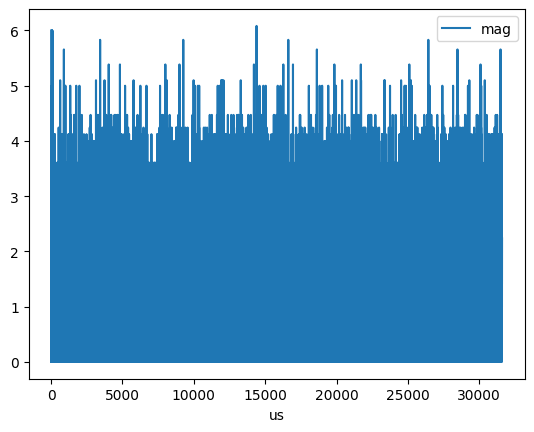

In [3]:
FREQ = 5500

# one flat-top pulse, two user-defined loop levels
class Sweep2DProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1, mixer_freq=5000)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_loop("loop1", self.cfg["steps1"]) # this will be the outer loop
        self.add_loop("loop2", self.cfg["steps2"]) # this will be the inner loop
        # the reps loop is always outermost, so the order and the shape of the raw data will be (reps, loop1, loop2)

        self.add_gauss(ch=gen_ch, name="ramp", sigma=cfg['ramp_len']/10, length=cfg['ramp_len'], even_length=True)
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=0*cfg['gain'], 
                      )

        self.delay(0.5) # give the tProc some time for initial setup
        self.trigger(ddr4=True, mr=True, t=0)

        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)
        # send the config to the dynamic RO
        self.send_readoutconfig(ch=ro_ch, name="myro", t=0)
        
    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

# similar sweep, but use the DDR4 buffer to see the loop order
config = {'steps1': 4,
          'steps2': 5,
          'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': 0.5,
          'ro_len': 0.35,
          'flat_len': 0.05,
          'ramp_len': 0.2,
          'phase': QickSweep1D("loop2", 0, 180),
          'gain': QickSweep1D("loop1", 0.5, 1.0)
         }



prog = Sweep2DProgram(soccfg, reps=3, final_delay=1.0, cfg=config)

n_transfers = 100000 # each transfer (aka burst) is 256 decimated samples
# Arm the buffers
soc.arm_ddr4(ch=RO_CH, nt=n_transfers)
soc.arm_mr(ch=RO_CH)



iq_list = prog.acquire(soc, soft_avgs=1, progress=True)

# now you see the loop order: innermost loop of 5 phase steps, mid loop of 4 gain steps, outer loop of 3 identical reps
iq_ddr4 = soc.get_ddr4(250)
t = prog.get_time_axis_ddr4(RO_CH, iq_ddr4)

#plt.plot(t, iq_ddr4[:,0],label="I")
#plt.plot(t, iq_ddr4[:,1],label="Q")
plt.plot(np.abs(iq_ddr4.dot([1,1j])),label="mag")
plt.xlabel("us")
plt.legend();

# looking at a TOF pulse in acquire_decimated() vs ddr4

In [8]:
class const_pulse(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1, mixer_freq=5000)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name='ro', freq=cfg['freq'], gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['pulse_len'],
                       freq=cfg['freq'], 
                       phase=0,
                       gain=cfg['gain'], 
                      )

    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name='ro', t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)
        self.pulse(ch=cfg['gen_ch'], name="pulse", t=0)

config = {'gen_ch': GEN_CH, # 0
          'ro_ch': RO_CH, # 0
          'freq': 5500,
          'trig_time': 0,
          'ro_len': 8,
          'gain': 1,
          'pulse_len': 4
         }

prog = const_pulse(soccfg, reps=1, final_delay=None, cfg=config)

  0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 1.0, 'constant pulse, acquire_decimated()')

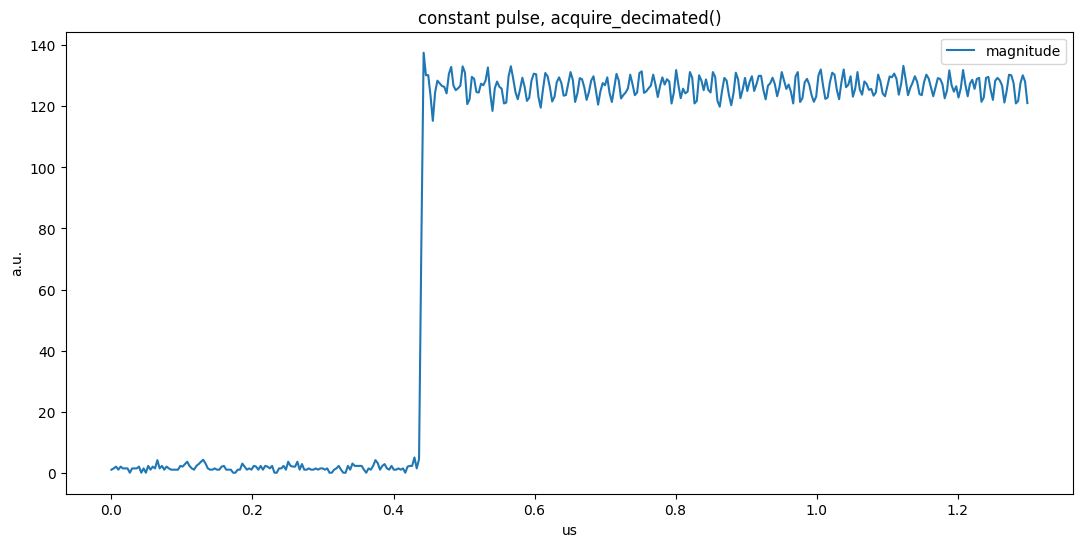

In [30]:
iq_list_decimated = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)
i = iq_list_decimated[0][:,0]
q = iq_list_decimated[0][:,1]
mag = np.abs(iq_list_decimated[0].dot([1,1j]))

fig = plt.figure(figsize=(13,6))
plt.plot(t[:400], mag[:400], label="magnitude")
# plt.plot(t, q, label="q")
# plt.plot(t, i, label="i")

plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us")
plt.title("constant pulse, acquire_decimated()")

  0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 1.0, 'constant pulse, DDR4')

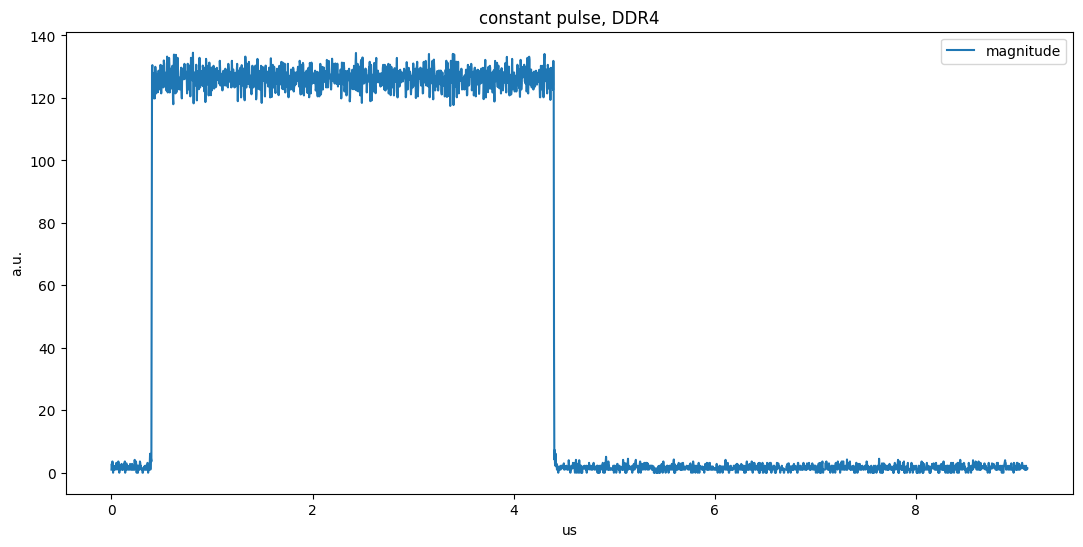

In [11]:
soc.arm_ddr4(ch=RO_CH, nt=100000)
prog.acquire(soc)
iq_list_DDR4 = soc.get_ddr4(25)
t = prog.get_time_axis_ddr4(RO_CH, iq_list_DDR4)
i = iq_list_DDR4[:,0]
q = iq_list_DDR4[:,1]
mag = np.abs(i + 1j*q)

fig = plt.figure(figsize=(13,6))
plt.plot(t, mag, label="magnitude")
# plt.plot(t, q, label="q")
# plt.plot(t, i, label="i")

plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us")
plt.title("constant pulse, DDR4")

In [17]:
soc.clear_ddr4()

# finding number of samples in one second of DDR4

  0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 1.0, 'constant pulse, DDR4')

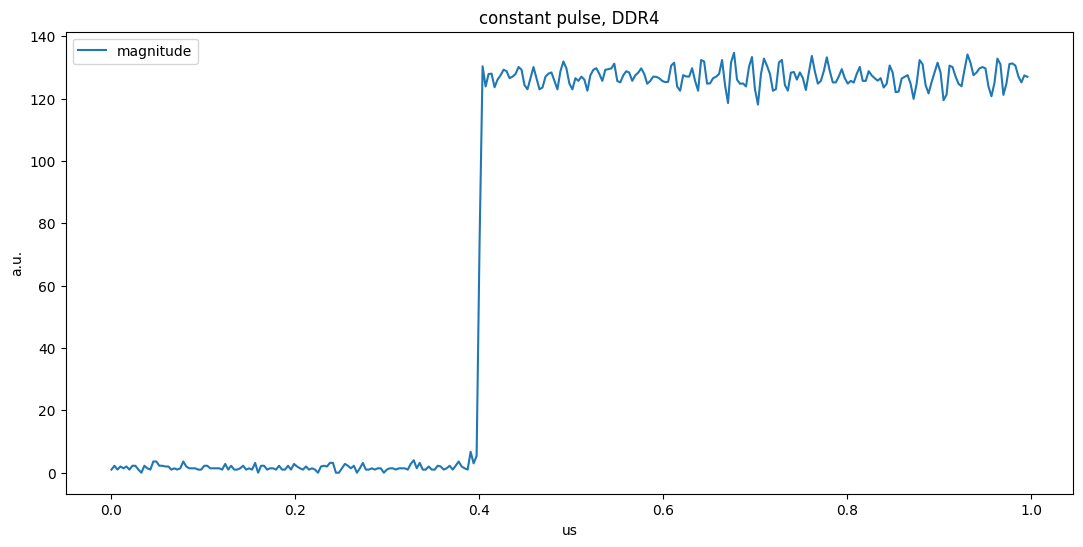

In [35]:
soc.arm_ddr4(ch=RO_CH, nt=1000000)
prog.acquire(soc)
iq_list_DDR4 = soc.get_ddr4(6)
t = prog.get_time_axis_ddr4(RO_CH, iq_list_DDR4)
i = iq_list_DDR4[:,0]
q = iq_list_DDR4[:,1]
mag = np.abs(i + 1j*q)

fig = plt.figure(figsize=(13,6))
plt.plot(t[:one_second], mag[:one_second], label="magnitude")
# plt.plot(t, q, label="q")
# plt.plot(t, i, label="i")

plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us")
plt.title("constant pulse, DDR4")

In [34]:
one_second = 307

# multiple pulses with one microsecond delay

  0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 1.0, 'constant pulse, DDR4')

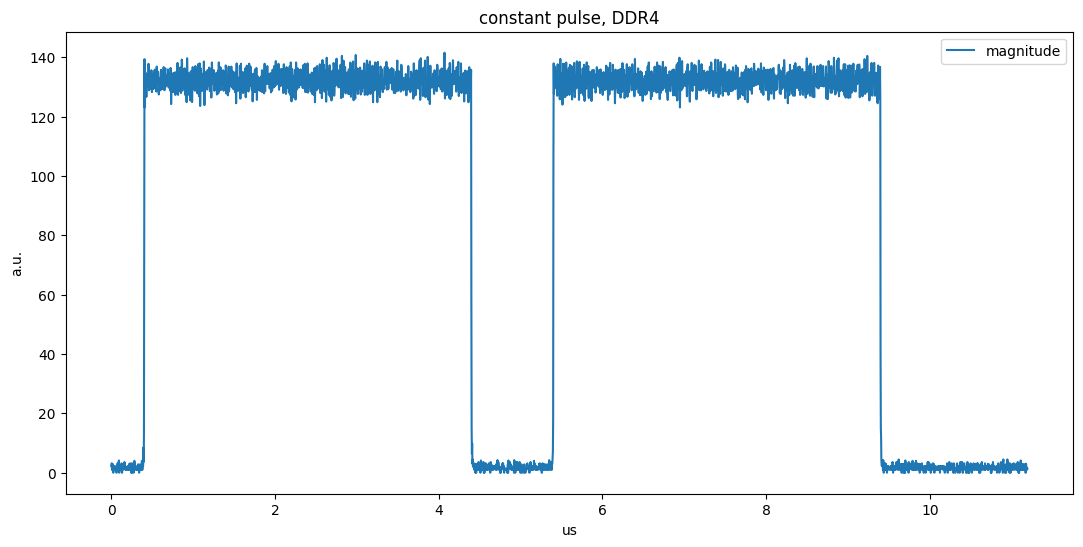

In [62]:
class const_pulse(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1, mixer_freq=5000)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name='ro', freq=cfg['freq'], gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['pulse_len'],
                       freq=cfg['freq'], 
                       phase=0,
                       gain=cfg['gain'], 
                      )

    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name='ro', t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)
        self.pulse(ch=cfg['gen_ch'], name="pulse", t=0)
        self.pulse(ch=cfg['gen_ch'], name="pulse", t=cfg['pulse_len']+1)

config = {'gen_ch': GEN_CH, # 0
          'ro_ch': RO_CH, # 0
          'freq': 5500,
          'trig_time': 0,
          'ro_len': 8,
          'gain': 1,
          'pulse_len': 4
         }

prog = const_pulse(soccfg, reps=1, final_delay=None, cfg=config)

soc.arm_ddr4(ch=RO_CH, nt=1000000)
prog.acquire(soc)
iq_list_DDR4 = soc.get_ddr4(30)
t = prog.get_time_axis_ddr4(RO_CH, iq_list_DDR4)
i = iq_list_DDR4[:,0]
q = iq_list_DDR4[:,1]
mag = np.abs(i + 1j*q)

fig = plt.figure(figsize=(13,6))
plt.plot(t[start:end], mag[start:end], label="magnitude")
# plt.plot(t, q, label="q")
# plt.plot(t, i, label="i")

plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us")
plt.title("constant pulse, DDR4")

In [60]:
start=0
end=30000

# sweep in ddr4

  0%|          | 0/4 [00:00<?, ?it/s]

Text(0.5, 1.0, 'constant pulse, DDR4')

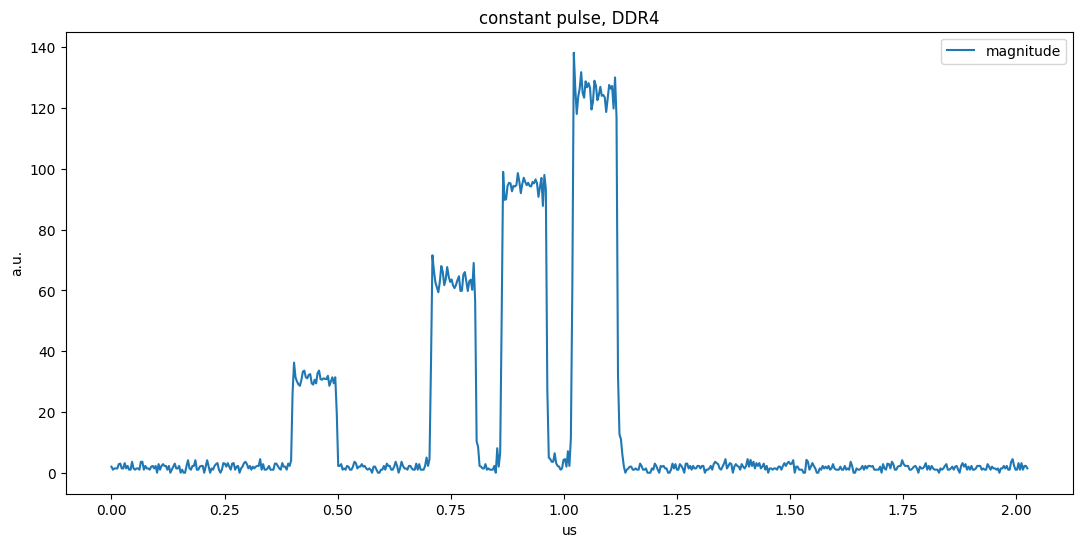

In [9]:
class const_pulse(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1, mixer_freq=5000)
        self.declare_readout(ch=ro_ch, length=cfg['pulse_len'])
        self.add_readoutconfig(ch=ro_ch, name='ro', freq=cfg['freq'], gen_ch=gen_ch)

        self.add_loop(name="gain_loop", count=cfg['steps'])

        self.add_pulse(ch=gen_ch, name="pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['pulse_len'],
                       freq=cfg['freq'], 
                       phase=0,
                       gain=cfg['gain'], 
                      )

    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name='ro', t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)
        self.pulse(ch=cfg['gen_ch'], name="pulse", t=0)

config = {'gen_ch': GEN_CH, # 0
          'ro_ch': RO_CH, # 0
          'freq': 5500,
          'trig_time': 0,
          'pulse_len': 0.1,
          'gain': QickSweep1D('gain_loop', 0.25, 1),
          'steps': 4
         }

prog = const_pulse(soccfg, reps=1, final_delay=None, cfg=config)

soc.arm_ddr4(ch=RO_CH, nt=100000)
prog.acquire(soc)
iq_list_DDR4 = soc.get_ddr4(8)
t = prog.get_time_axis_ddr4(RO_CH, iq_list_DDR4)
i = iq_list_DDR4[:,0]
q = iq_list_DDR4[:,1]
mag = np.abs(i + 1j*q)

fig = plt.figure(figsize=(13,6))
plt.plot(t, mag, label="magnitude")

plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us")
plt.title("constant pulse, DDR4")

# program of consecutive constant pulses, to compare

  0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 1.0, 'constant pulse, DDR4')

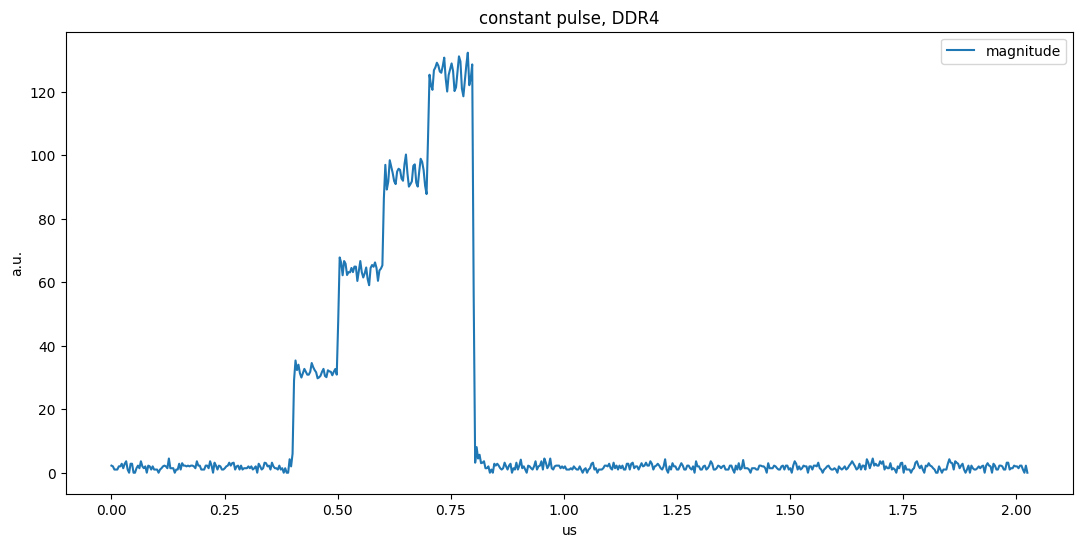

In [8]:
class const_pulse(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1, mixer_freq=5000)
        self.declare_readout(ch=ro_ch, length=cfg['pulse_len'])
        self.add_readoutconfig(ch=ro_ch, name='ro', freq=cfg['freq'], gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="pulse1", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['pulse_len'],
                       freq=cfg['freq'], 
                       phase=0,
                       gain=0.25, 
                      )
        self.add_pulse(ch=gen_ch, name="pulse2", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['pulse_len'],
                       freq=cfg['freq'], 
                       phase=0,
                       gain=0.5, 
                      )
        self.add_pulse(ch=gen_ch, name="pulse3", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['pulse_len'],
                       freq=cfg['freq'], 
                       phase=0,
                       gain=0.75, 
                      )
        self.add_pulse(ch=gen_ch, name="pulse4", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['pulse_len'],
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1, 
                      )

    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name='ro', t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)
        self.pulse(ch=cfg['gen_ch'], name="pulse1", t=0)
        self.pulse(ch=cfg['gen_ch'], name="pulse2", t=cfg['pulse_len'])
        self.pulse(ch=cfg['gen_ch'], name="pulse3", t=cfg['pulse_len']*2)
        self.pulse(ch=cfg['gen_ch'], name="pulse4", t=cfg['pulse_len']*3)

config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': 5500,
          'trig_time': 0,
          'pulse_len': 0.1,
         }

prog = const_pulse(soccfg, reps=1, final_delay=None, cfg=config)

soc.arm_ddr4(ch=RO_CH, nt=100000)
prog.acquire(soc)
iq_list_DDR4 = soc.get_ddr4(8)
t = prog.get_time_axis_ddr4(RO_CH, iq_list_DDR4)
i = iq_list_DDR4[:,0]
q = iq_list_DDR4[:,1]
mag = np.abs(i + 1j*q)

fig = plt.figure(figsize=(13,6))
plt.plot(t, mag, label="magnitude")

plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us")
plt.title("constant pulse, DDR4")

# Single-shot in DDR4

  0%|          | 0/4 [00:00<?, ?it/s]

Text(0.5, 1.0, 'constant pulse, DDR4')

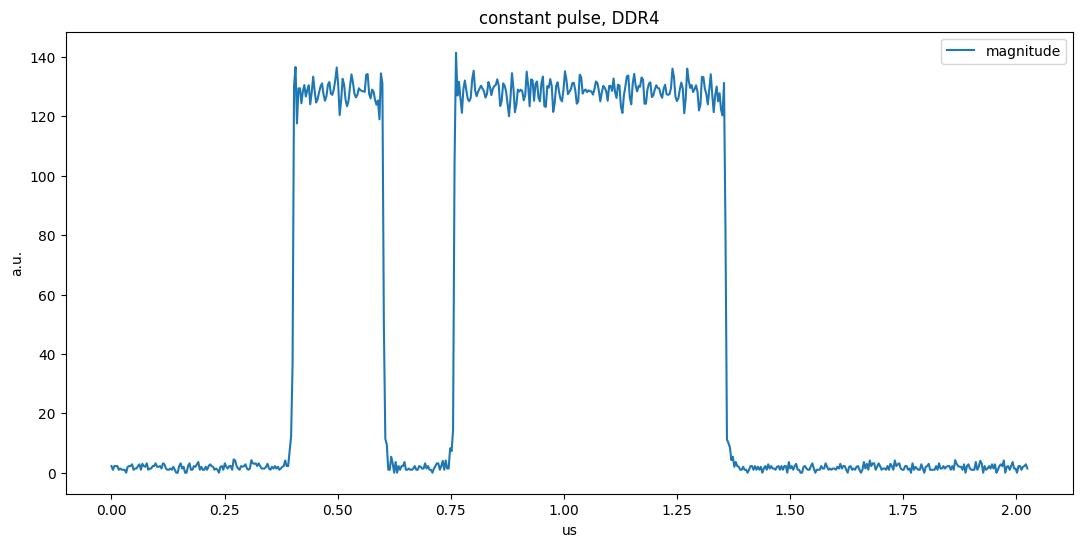

In [14]:
class const_pulse(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1, mixer_freq=5000)
        self.declare_readout(ch=ro_ch, length=cfg['pulse_len'])
        self.add_readoutconfig(ch=ro_ch, name='ro', freq=cfg['freq'], gen_ch=gen_ch)

        self.add_loop(name="iter_loop", count=cfg['steps'])

        self.add_pulse(ch=gen_ch, name="pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['pulse_len'],
                       freq=cfg['freq'], 
                       phase=0,
                       gain=cfg['gain'], 
                      )

    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name='ro', t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)
        self.pulse(ch=cfg['gen_ch'], name="pulse", t=0)

config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': 5500,
          'trig_time': 0,
          'pulse_len': 0.2,
          'gain': 1,
          'steps': 4
         }

prog = const_pulse(soccfg, reps=1, final_delay=None, cfg=config)

soc.arm_ddr4(ch=RO_CH, nt=100000)
prog.acquire(soc)
iq_list_DDR4 = soc.get_ddr4(8)
t = prog.get_time_axis_ddr4(RO_CH, iq_list_DDR4)
i = iq_list_DDR4[:,0]
q = iq_list_DDR4[:,1]
mag = np.abs(i + 1j*q)

fig = plt.figure(figsize=(13,6))
plt.plot(t, mag, label="magnitude")

plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us")
plt.title("constant pulse, DDR4")